<a href="https://colab.research.google.com/github/gibranfp/CursoDatosMasivosI/blob/main/notebooks/2b_map_reduce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. *MapReduce*


En este notebook haremos una revisión aplicada de operaciones Map y Reduce.


## 2.1 Introducción


*MapReduce* es un modelo de programación que nos permite procesar enormes cantidades de datos de forma distribuida sobre un *cluster*. 


La idea principal detrás de este modelo de programación consiste en primero transformar los datos de tal forma que tengan un formato `(llave, valor)`  para después reducir los datos, combinando de alguna manera todos los valores correspondientes a la misma `llave`.


Para realizar este proceso solo es necesario definir dos funciones:


* *Map*: Transforma los datos en pares `(llave, valor)`.
* *Reduce*: Combina todos los valores asociados a la misma `llave` de alguna forma.


El gran atractivo que tiene este modelo de programación es que permite a herramientas como *Spark* procesar grandes cantidades de datos sobre un *cluster* si no que incluso puede evitar que fallas en los nodos del *cluster* afecten los cálculos y procesos realizados con los datos.


En este notebook nos daremos a la tarea de mostrar varios ejemplos de como llevar a cabo este modelo de programación usando `Python` y `PySpark`.


Antes de pasar a los ejemplos debemos instalar nuestro entorno de desarrollo con `PySpark`.

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

openjdk-8-jdk-headless is already the newest version (8u282-b08-0ubuntu1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


Para empezar a hacer uso de PySpark es necesario crear una `SparkSession`, dicho objeto es el que nos permitirá crear RDDs o DataFrames, que son los objetos con los que más estaremos trabajando

In [ ]:
import pyspark
# Carga ufnciones extra
from pyspark.sql.functions import * 
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('MapReduce').getOrCreate()

Ademas de `PySpark` usaremos usaremos las siguientes bibliotecas

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Procesamiento del lenguaje natural
!pip install nltk
!pip install --upgrade pip
!python -m nltk.downloader all

import nltk
import string

# Experimental?

!pip install sentiment-analysis-spanish
!pip install keras tensorflow

from sentiment_analysis_spanish import sentiment_analysis

## 2.2 Ejemplos


En esta sección revisaremos con ejemplos muy sencillos algunas de las combinaciones de funciones *Map* y *Reduce* más comunes. Estos ejemplos usan datos muy sencillos.


### 2.2.1 `reduce`


La operación *Reduce* asume que todos los valores corresponden a la misma llave, es decir se toma la función *Map* como la función identidad.


Creemos un RDD a partir cuyos elementos sean 500 números enteros, estos los crearemos de forma aleatoria usando numpy

In [ ]:
np.random.seed(182)
dat_numeros = np.random.randint(10, size=1000)
# Veamos una muestra
dat_numeros[:10]

array([9, 8, 2, 2, 2, 5, 8, 8, 7, 2])

creemos el RDD

In [ ]:
rdd_numeros = spark.sparkContext.parallelize(dat_numeros)

# Revisemos el contenido del RDD
for elemento in rdd_numeros.take(5):
  print(elemento)

9
8
2
2
2


Podemos usar la función *Reduce* para saber, por ejemplo, la suma de todos los elementos

In [ ]:
suma = rdd_numeros.reduce(lambda a, b: a + b)
suma

4323

También podríamos querer saber cual es el elemento máximo

In [ ]:
maximo = rdd_numeros.reduce(lambda a, b: a if a > b else b)
maximo

9

### 2.2.2 `map`


Supongamos ahora que queremos saber la distribución de números en los datos, para esto tendremos que contar cuantas veces aparece cada numero, para esto podemos mapear los elemento de tal forma que cada elemento `numero` al par cuya llave sea el numero y el valor el numero de apariciones de dicho numero en cada renglón, es decir `(numero, 1)`. Esto lo podemos lograr con la función `map` de la siguiente forma

In [ ]:
rdd_conteo = rdd_numeros.map(lambda x: (x, 1))

for elemento in rdd_conteo.take(5):
  print(elemento)

(9, 1)
(8, 1)
(2, 1)
(2, 1)
(2, 1)


La función *map* también la podemos usar para transformar a los elementos del RDD de la forma en que queramos. Por ejemplo, podríamos querer obtener las 3 primeras potencias de cada elemento

In [ ]:
# Podemos pasar una funcion 
def potencias(x):
  return (x**1, x**2, x**3)

# Aplicamos la funcion
rdd_potencias = rdd_numeros.map(potencias)

# Imprimimos 
for elemento in rdd_potencias.take(5):
  print(elemento)

(9, 81, 729)
(8, 64, 512)
(2, 4, 8)
(2, 4, 8)
(2, 4, 8)


### 2.2.3 `reduceByKey`

Habiendo transformado nuestros datos en pares `(llave, etiqueta)` podemos aplicar una función de *Reduce*, para saber cuantas veces aparece cada numero solo debemos sumar los valores para cada llave. Esto lo logramos de la siguiente manera

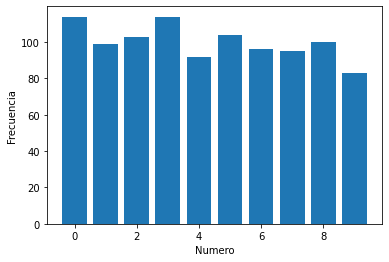

In [ ]:
# Calculamos la suma para cada llave
rdd_histograma = rdd_conteo.reduceByKey(lambda a, b: a + b)

# Imprimimos el histograma

histograma = rdd_histograma.collect()

numeros = [ numero for (numero, _) in histograma ]
frecuencias = [ frecuencia for (_, frecuencia) in histograma ]
plt.bar(numeros, frecuencias)
plt.xlabel('Numero')
plt.ylabel('Frecuencia')
plt.show()

### 2.2.4 `flatMap`

Supongamos ahora que tenemos un texto separado por renglones de la siguiente manera

In [ ]:
texto = ['esto se supone que es un parrafo del texto', 'este es el segundo parrafo del texto', 'agreguemos otro parrafo']

Carguemos este texto a un RDD

In [ ]:
rdd_texto = spark.sparkContext.parallelize(texto)

for parrafo in rdd_texto.collect():
  print(parrafo)

esto se supone que es un parrafo del texto
este es el segundo parrafo del texto
agreguemos otro parrafo


Pensemos que queremos contar cuantas veces aparece cada palabra en todo el texto. Una forma de hacerlo es creando pares `(palabra, 1)` (parecido al ejemplo pasado), sin embargo los elementos del RDD deberían ser las palabras no los párrafos. 


Para esto existe la función `flatMap`, nos ayuda a *aplanar* los elementos del RDD. Veamos como funciona

In [ ]:
rdd_palabras = rdd_texto.flatMap(lambda parrafo: parrafo.split(' '))

for palabra in rdd_palabras.take(10):
  print(palabra)

esto
se
supone
que
es
un
parrafo
del
texto
este


Hagamos el conteo de palabras

In [ ]:
histograma_palabras = rdd_palabras.map(lambda palabra: (palabra, 1)) \
                                  .reduceByKey(lambda a, b: a + b) \
                                  .sortBy(lambda x: x[1], ascending = False) \
                                  .collect()


print ("{:<10} {:<10}".format('PALABRA', 'FRECUENCIA'))

for palabra, frecuencia in histograma_palabras:
  print ("{:<10} {:<10}".format(palabra, frecuencia))

PALABRA    FRECUENCIA
parrafo    3         
del        2         
es         2         
texto      2         
esto       1         
supone     1         
que        1         
este       1         
el         1         
segundo    1         
se         1         
un         1         
agreguemos 1         
otro       1         


En este ejemplo podemos separar la parte de *Map* y *Reduce* de la siguiente forma

In [ ]:
# Map
rdd_par_palabras = rdd_texto.flatMap(lambda parrafo: parrafo.split(' ')) \
                            .map(lambda palabra: (palabra, 1))

print('Resultado del Map')
for par in rdd_par_palabras.take(5):
  print(par)

# Reduce
rdd_histograma_palabras = rdd_par_palabras.reduceByKey(lambda a, b: a + b) \
                                      .sortBy(lambda x: x[1], ascending = False)

print('Resultado del Reduce')
for par in rdd_histograma_palabras.take(5):
  print(par)                                  

Resultado del Map
('esto', 1)
('se', 1)
('supone', 1)
('que', 1)
('es', 1)
Resultado del Reduce
('parrafo', 3)
('del', 2)
('es', 2)
('texto', 2)
('esto', 1)


### 2.2.5 `mapValues`


Otra función que puede resultar útil al momento de crear funciones Map es la de `mapValues`. Imaginemos que ahora tenemos tres textos diferentes

In [ ]:
# Definicion de los texto
texto_1 = ['esto es un parrafo', 'otro_parrafo']
texto_2 = ['este texto solo tiene un parrafo']
texto_3 = ['parrafo 1', 'parrafo 2', 'parrafo 3']

textos = [('texto_1', texto_1), ('texto_2', texto_2), ('texto_3', texto_3)]

# Creamos un RDD con los textos
rdd_textos = spark.sparkContext.parallelize(textos)

for texto in rdd_textos.take(1):
  print(texto)

('texto_1', ['esto es un parrafo', 'otro_parrafo'])


Notemos que este RDD ya está formateado en pares `(texto_id, texto)`. Si quisiéramos saber cuantos párrafos tiene cada texto deberíamos encontrar una forma de calcular `len(texto)` para cada par sin alterar la llave. Podemos hacer esto usando la función `mapValues`, que dado un par `(llave, valor)` aplica una transformación solo al valor

In [ ]:
rdd_num_parrafos = rdd_textos.mapValues(lambda valor: len(valor))

print ("{:<10} {:<10}".format('TEXTO', 'NUM_PARRAFOS'))

for texto, num_parrafos in rdd_num_parrafos.collect():
  print ("{:<10} {:<10}".format(texto, num_parrafos))

TEXTO      NUM_PARRAFOS
texto_1    2         
texto_2    1         
texto_3    3         


En esta sección hemos revisado algunas de las funciones más importantes para la creación de funciones *Map* y *Reduce*, sin embargo, las hemos aplicado a datos bastante sintéticos. Hagamos un ejemplo con datos más reales.


## 2.3 Caso de uso




### 2.3.1 Datos


En nuestro caso de uso emplearemos una base de datos que contiene las letras del top 10 de canciones en México según spotify (esto es para el día 4 de marzo de 2021). Por simplicidad se han omitido las canciones que estén en ingles.


La base de datos cuenta con los siguientes campos **canción**, **artista** y **letra** separados por el caracter '*'. Carguemos los datos

In [ ]:
rdd_letras = spark.sparkContext.textFile('/content/drive/MyDrive/datos/top_10_mexico.csv').map(lambda x: x.split('*'))

for cancion in rdd_letras.take(1):
  print(cancion)

['Bad Bunny, Jhay Cortez', 'DÁKITI', "Baby, ya yo me enteré, se nota cuando me ve' Ahí donde no has llegao' sabes que yo te llevaré Y dime qué quieres beber, es que tú eres mi bebé ¿Y de nosotros quién va a hablar? Si no nos dejamos ver Y a veces es Dolce, a veces Bulgari Cuando te lo quito después de los parties Las copas de vino, las libras de mari Tú estás bien suelta, yo de safari Tú mueve' el culo fenomenal Pa' yo devorarte como animal Si no te has vení'o, yo te vo' a esperar En mi cama y lo vo' a celebrar Baby, a ti no me opongo Y siempre te lo pongo Y si tú me tiras, vamo' a nadar en lo hondo Si es por mí te lo pongo De septiembre hasta agosto A mí sin cojone' lo que digan tus amigas Ya yo me enteré, se nota cuando me ve' Ahí donde no has llegao' sabes que yo te llevaré Y dime qué quieres beber, es que tú eres mi bebé ¿Y de nosotros quién va a hablar? Si no nos dejamos ver (¿me sigues?) Mami, me tienes juqueao', sí Si fueras la Uru, me tuvieses parqueao' Dando vueltas por Condad

### 2.3.2 Limpieza de datos


Notemos que las letras de canciones, como el texto en general, deben ser preprocesados para poder analizados de una forma más eficiente. En nuestro caso nos enfocaremos en los siguientes puntos:


* Transformar todo el texto a minúsculas.
* Eliminar signos de puntuación.
* Eliminar las *palabras vacías*, que son palabras que aportan poco contexto al problema.




Empecemos transformando las letras a minúsculas

In [ ]:
rdd_letras = rdd_letras.map(lambda x: (x[0], x[1], x[2].lower()))

for letra in rdd_letras.take(1):
  print(letra[2])

baby, ya yo me enteré, se nota cuando me ve' ahí donde no has llegao' sabes que yo te llevaré y dime qué quieres beber, es que tú eres mi bebé ¿y de nosotros quién va a hablar? si no nos dejamos ver y a veces es dolce, a veces bulgari cuando te lo quito después de los parties las copas de vino, las libras de mari tú estás bien suelta, yo de safari tú mueve' el culo fenomenal pa' yo devorarte como animal si no te has vení'o, yo te vo' a esperar en mi cama y lo vo' a celebrar baby, a ti no me opongo y siempre te lo pongo y si tú me tiras, vamo' a nadar en lo hondo si es por mí te lo pongo de septiembre hasta agosto a mí sin cojone' lo que digan tus amigas ya yo me enteré, se nota cuando me ve' ahí donde no has llegao' sabes que yo te llevaré y dime qué quieres beber, es que tú eres mi bebé ¿y de nosotros quién va a hablar? si no nos dejamos ver (¿me sigues?) mami, me tienes juqueao', sí si fueras la uru, me tuvieses parqueao' dando vueltas por condado, contigo siempre arrebatao' tú no er

Para poder tratar con el texto a nivel de palabras debemos hacer lo siguiente

In [ ]:
rdd_letras = rdd_letras.map(lambda x: (x[0], x[1], x[2].split(' ')))

for letra in rdd_letras.take(1):
  l = letra[2]
  print(letra[2])

['baby,', 'ya', 'yo', 'me', 'enteré,', 'se', 'nota', 'cuando', 'me', "ve'", 'ahí', 'donde', 'no', 'has', "llegao'", 'sabes', 'que', 'yo', 'te', 'llevaré', 'y', 'dime', 'qué', 'quieres', 'beber,', 'es', 'que', 'tú', 'eres', 'mi', 'bebé', '¿y', 'de', 'nosotros', 'quién', 'va', 'a', 'hablar?', 'si', 'no', 'nos', 'dejamos', 'ver', 'y', 'a', 'veces', 'es', 'dolce,', 'a', 'veces', 'bulgari', 'cuando', 'te', 'lo', 'quito', 'después', 'de', 'los', 'parties', 'las', 'copas', 'de', 'vino,', 'las', 'libras', 'de', 'mari', 'tú', 'estás', 'bien', 'suelta,', 'yo', 'de', 'safari', 'tú', "mueve'", 'el', 'culo', 'fenomenal', "pa'", 'yo', 'devorarte', 'como', 'animal', 'si', 'no', 'te', 'has', "vení'o,", 'yo', 'te', "vo'", 'a', 'esperar', 'en', 'mi', 'cama', 'y', 'lo', "vo'", 'a', 'celebrar', 'baby,', 'a', 'ti', 'no', 'me', 'opongo', 'y', 'siempre', 'te', 'lo', 'pongo', 'y', 'si', 'tú', 'me', 'tiras,', "vamo'", 'a', 'nadar', 'en', 'lo', 'hondo', 'si', 'es', 'por', 'mí', 'te', 'lo', 'pongo', 'de', 'septi

Ahora eliminemos los signos de puntuación

In [ ]:
# Agregamos los simbolos usado en espanol
signos_puntuacion = list(string.punctuation) + ['¡', '¿']

def elimina_puntuacion(letra):
  letra_limpia = [''.join(caracter for caracter in palabra if caracter not in signos_puntuacion) for palabra in letra] 
  return letra_limpia

rdd_letras = rdd_letras.map(lambda x: (x[0], x[1], elimina_puntuacion(x[2])))

for letra in rdd_letras.take(1):
  print(letra[2])

['baby', 'ya', 'yo', 'me', 'enteré', 'se', 'nota', 'cuando', 'me', 've', 'ahí', 'donde', 'no', 'has', 'llegao', 'sabes', 'que', 'yo', 'te', 'llevaré', 'y', 'dime', 'qué', 'quieres', 'beber', 'es', 'que', 'tú', 'eres', 'mi', 'bebé', 'y', 'de', 'nosotros', 'quién', 'va', 'a', 'hablar', 'si', 'no', 'nos', 'dejamos', 'ver', 'y', 'a', 'veces', 'es', 'dolce', 'a', 'veces', 'bulgari', 'cuando', 'te', 'lo', 'quito', 'después', 'de', 'los', 'parties', 'las', 'copas', 'de', 'vino', 'las', 'libras', 'de', 'mari', 'tú', 'estás', 'bien', 'suelta', 'yo', 'de', 'safari', 'tú', 'mueve', 'el', 'culo', 'fenomenal', 'pa', 'yo', 'devorarte', 'como', 'animal', 'si', 'no', 'te', 'has', 'venío', 'yo', 'te', 'vo', 'a', 'esperar', 'en', 'mi', 'cama', 'y', 'lo', 'vo', 'a', 'celebrar', 'baby', 'a', 'ti', 'no', 'me', 'opongo', 'y', 'siempre', 'te', 'lo', 'pongo', 'y', 'si', 'tú', 'me', 'tiras', 'vamo', 'a', 'nadar', 'en', 'lo', 'hondo', 'si', 'es', 'por', 'mí', 'te', 'lo', 'pongo', 'de', 'septiembre', 'hasta', 'a

Eliminamos las *palabras vacías*

In [ ]:
palabras_vacias = nltk.corpus.stopwords.words('spanish') + ['']

def quita_palabras_vacias(letra):
  letra_limpia = [palabra for palabra in letra if palabra not in palabras_vacias]
  return letra_limpia

rdd_letras = rdd_letras.map(lambda x: (x[0], x[1], quita_palabras_vacias(x[2])))

for letra in rdd_letras.take(1):
  print(letra[2])

['baby', 'enteré', 'nota', 've', 'ahí', 'llegao', 'sabes', 'llevaré', 'dime', 'quieres', 'beber', 'bebé', 'quién', 'va', 'hablar', 'si', 'dejamos', 'ver', 'veces', 'dolce', 'veces', 'bulgari', 'quito', 'después', 'parties', 'copas', 'vino', 'libras', 'mari', 'bien', 'suelta', 'safari', 'mueve', 'culo', 'fenomenal', 'pa', 'devorarte', 'animal', 'si', 'venío', 'vo', 'esperar', 'cama', 'vo', 'celebrar', 'baby', 'opongo', 'siempre', 'pongo', 'si', 'tiras', 'vamo', 'nadar', 'hondo', 'si', 'pongo', 'septiembre', 'agosto', 'cojone', 'digan', 'amigas', 'enteré', 'nota', 've', 'ahí', 'llegao', 'sabes', 'llevaré', 'dime', 'quieres', 'beber', 'bebé', 'quién', 'va', 'hablar', 'si', 'dejamos', 'ver', 'sigues', 'mami', 'juqueao', 'si', 'uru', 'parqueao', 'dando', 'vueltas', 'condado', 'contigo', 'siempre', 'arrebatao', 'señora', 'toma', 'cinco', 'mil', 'gástalo', 'sephora', 'louis', 'vuitton', 'compra', 'pandora', 'piercing', 'hombres', 'perfora', 'eheheh', 'hace', 'tiempo', 'rompieron', 'cora', 'co

### 2.3.3 Palabras más usadas


Ya con los datos limpios podemos hacer algunos análisis. Veamos cuales son las palabras más empleadas en las letras de las canciones


In [ ]:
rdd_palabras_histograma = rdd_letras.map(lambda x: [(palabra, 1) for palabra in x[2]]) \
                         .flatMap(lambda x: x) \
                         .reduceByKey(lambda a, b: a + b) \
                         .sortBy(lambda x: x[1], ascending = False)

print ("{:<10} {:<10}".format('PALABRA', 'FRECUENCIA'))                     

for palabra, frecuencia in rdd_palabras_histograma.take(30):
  print ("{:<10} {:<10}".format(palabra, frecuencia))

PALABRA    FRECUENCIA
baila      60        
si         52        
pa         46        
eh         46        
baby       33        
pumpum     20        
ahora      19        
ey         15        
solo       15        
prada      15        
gucci      15        
sigo       14        
conmigo    14        
yeah       14        
oh         13        
ver        12        
noche      12        
bien       11        
encima     11        
corazón    11        
vez        11        
tiempo     11        
na         11        
va         10        
wuh        10        
amor       10        
pégate     10        
ven        10        
así        10        
balenciaga 10        


### 2.3.4 Análisis de sentimientos


Usaremos la biblioteca `sentiment_analysis` para realizar el análisis de sentimiento de las letras de canciones. En la documentación menciona que se calcula la probabilidad de que el texto sea clasificado como positivo. Aunque se menciona que existe un rango entre 0 y 1 para los cuales el texto se considera neutro, dado que no se especifica dichos umbrales, en este caso solo clasificaremos las palabras entre positivas y negativas.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MultinomialNB from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


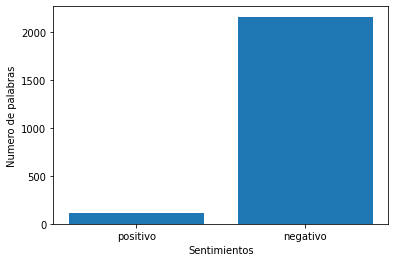

In [ ]:
sentiment = sentiment_analysis.SentimentAnalysisSpanish()

def sentimiento(palabra):

  prob = sentiment.sentiment(palabra)

  if prob >= 0.5:
    return 'positivo'
  else:
    return 'negativo'

histograma_sentimientos = rdd_letras.flatMap(lambda x: x[2]) \
                                    .map(lambda x: (sentimiento(x), 1)) \
                                    .reduceByKey(lambda a, b: a + b) \
                                    .collect()

sentimientos = [ sentimiento for (sentimiento, _) in histograma_sentimientos ]
frecuencias = [ frecuencia for (_, frecuencia) in histograma_sentimientos ]
plt.bar(sentimientos, frecuencias)
plt.xlabel('Sentimientos')
plt.ylabel('Numero de palabras')
plt.show()

## Ejercicio

Encuentre en cuales canciones se encuentra cada palabra. Es decir, calcule un RDD cuyos elementos sean `(palabra, (cancion_1, cancion_3))`.


*Hint: Investigue la función flatMapValues*